In [1]:
import joblib

joblib.parallel_config(backend="multiprocessing")

import joblib._store_backends
import sys

import random
import numpy as np
import torch
import openml
import types

import random
from sklearn.model_selection import train_test_split
from simple_model import ConformalRankingPredictor, ConformalPredictor, ClassifierModel
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)


master_seed = 1
rng = random.Random(master_seed)
mccv_split_seed = rng.randint(0, 2**32 - 1)
clf_seed = rng.randint(0, 2**32 - 1)

random.seed(clf_seed)
np.random.seed(clf_seed)
torch.manual_seed(clf_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(clf_seed)
    torch.cuda.manual_seed_all(clf_seed)

dataset = openml.datasets.get_dataset(187)
X, y, _, _ = dataset.get_data(
    target=dataset.default_target_attribute, dataset_format="dataframe"
)

# Automatically identify categorical and numerical columns
categorical_features = X.select_dtypes(
    include=["object", "category"]
).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=mccv_split_seed
)

# Encode labels
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Preprocessing for numerical data: Impute missing values, then scale
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# Preprocessing for categorical data: Impute missing values, then one-hot encode
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train = preprocessor.fit_transform(X_train)

model = ClassifierModel(
    input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes
)
predictor_clf = ConformalPredictor(model=model, alpha=0.05)
predictor_rnk = ConformalRankingPredictor(
    num_classes=num_classes, alpha=0.05, hidden_dim=16
)

if not isinstance(X_train, np.ndarray):
    X_train = X_train.toarray()
if not isinstance(y_train, np.ndarray):
    y_train = y_train.toarray()

predictor_clf.fit(
    X_train,
    y_train,
    cal_size=0.2,
    random_state=clf_seed,
)


predictor_rnk.fit(
    X_train,
    y_train,
    cal_size=0.2,
    random_state=clf_seed,
)


/home/jonas/Documents/Research/dyad_ranking/torch_plnet/.venv/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


In [2]:

X_test = preprocessor.transform(X_test)

# X_test = X_test.to_numpy()
if not isinstance(X_test, np.ndarray):
    X_test = X_test.toarray()
if not isinstance(y_test, np.ndarray):
    y_test = y_test.toarray()

y_pred_crisp_clf = predictor_clf.model.predict(X_test)
y_pred_set_clf = predictor_clf.predict_set(X_test)

y_pred_crisp_rnk = predictor_rnk.model.predict(X_test)
y_pred_set_rnk = predictor_rnk.predict_set(X_test)


# Classifcation metrics of crisp (point) prediction
score_f1_clf = f1_score(y_test, y_pred_crisp_clf, average="macro")
score_acc_clf = accuracy_score(y_test, y_pred_crisp_clf)
score_bacc_clf = balanced_accuracy_score(y_test, y_pred_crisp_clf)
score_f1_rnk = f1_score(y_test, y_pred_crisp_rnk, average="macro")
score_acc_rnk = accuracy_score(y_test, y_pred_crisp_rnk)
score_bacc_rnk = balanced_accuracy_score(y_test, y_pred_crisp_rnk)
# score_roc_auc = roc_auc_score(
#     y_test, y_pred_crisp, average="macro", multi_class="ovr"
# )

# Conformal prediction metrics
hits_clf = [y_test[i] in y_pred_set_clf[i] for i in range(len(y_test))]
lens_clf = [len(y_pred_set_clf[i]) for i in range(len(y_test))]
hits_rnk = [y_test[i] in y_pred_set_rnk[i] for i in range(len(y_test))]
lens_rnk = [len(y_pred_set_rnk[i]) for i in range(len(y_test))]

coverage_mean_clf = np.mean(hits_clf)
coverage_std_clf = np.std(hits_clf)
efficiency_mean_clf = np.mean(lens_clf)
efficiency_std_clf = np.std(lens_clf)

coverage_mean_rnk = np.mean(hits_rnk)
coverage_std_rnk = np.std(hits_rnk)
efficiency_mean_rnk = np.mean(lens_rnk)
efficiency_std_rnk = np.std(lens_rnk)

print("Clf: ", coverage_mean_clf, efficiency_mean_clf)
print("Rnk: ", coverage_mean_rnk, efficiency_mean_rnk)

Clf:  1.0 1.0
Rnk:  0.9722222222222222 1.2222222222222223


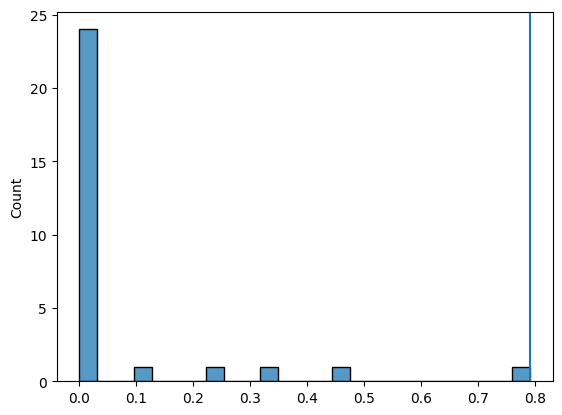

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.histplot(x=predictor_clf.scores, ax=ax, bins=25)
ax.axvline(x=predictor_clf.threshold)

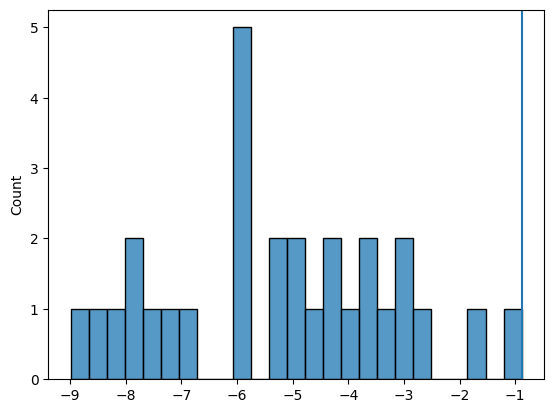

In [4]:
fig, ax = plt.subplots()

sns.histplot(x=predictor_rnk.scores.ravel(), ax=ax, bins=25)
ax.axvline(x=predictor_rnk.threshold)
print()

In [5]:
good_example = X_test[1].reshape(1,-1)

pred_set_clf = predictor_clf.predict_set(good_example)
pred_set_rnk = predictor_rnk.predict_set(good_example)
print("pred set clf", pred_set_clf)
print("pred set rnk", pred_set_rnk)
print("true label", y_test[1])

pred set clf [array([0])]
pred set rnk [array([0])]
true label 0


In [6]:
predictor_clf.model.predict_proba(good_example)

array([[9.9949014e-01, 1.6332378e-04, 3.4654079e-04]], dtype=float32)

In [7]:
predictor_clf.threshold

0.7914753

In [8]:
1 - predictor_clf.model.predict_proba(good_example)

array([[5.0985813e-04, 9.9983668e-01, 9.9965346e-01]], dtype=float32)

In [9]:
predictor_rnk.model.predict_class_skills(good_example)


array([[ 3.438745 , -3.6703255, -4.8003135]], dtype=float32)